# *AI Assignment*
Problem 1


In [0]:
# imports
from typing import List,Tuple
import numpy as np
from queue import PriorityQueue
import math
from scipy.optimize import curve_fit 
from matplotlib import pyplot as plt
import statistics
from multiprocessing import Process, Pool, Lock
import random

In [0]:
class Location:
    """
    Location of the maze Runner in the maze
    """
    def __init__(self, row: int, col: int):
        self.row = row
        self.col = col
        self.parent = None
        # cost paid to reach from start to this node
        self.cost = 0
        
    def equals(self, loc) -> bool:
        if self.row == loc.row and self.col == loc.col:
            return True
        return False
    
    def get_tuple(self) -> Tuple[int, int]:
        return (self.row, self.col)
    
    def out(self):
        print(self.row, self.col)
        
    def set_parent(self, parent):
        self.parent = parent
        
    def get_parent(self):
        return self.parent
    
    def __lt__(self, other):
        return (self.cost < other.cost)
    
    def __gt__(self, other):
        return (self.cost > other.cost)
    
    def __eq__(self, other):
        return (self.cost == other.cost)
        
class Maze:
    """
    dim: dimensions of the maze
    p: probability of occupancy
    map_arr: the generated maze
    """
    WALL = 1
    FIRE = 2
    
    def __init__(self):
        self.dim = None
        self.p = None        
        self.map_arr = None
        self.q = 0
    
    def generate_maze(self, dim: int, p: float):   
        """
        dim: Generate maps of dim X dim
        p: probability the square is blocked
        return: 2D array of the generated map, where 
            0 -> open 
            -1 -> occupied
        """
        # Generate dim X dim random numbers from parameterized binomial distribution of n=1
        # multiple with the value of WALL
        map_arr = np.random.binomial(1, p, dim*dim) * self.WALL
        # start and end should never be blocked
        map_arr[0] = map_arr[-1] = 0
        # reshape the array and create a dim X dim numpy array 
        map_arr = map_arr.reshape(dim, dim)
        # convert to python list and return
        self.map_arr = map_arr.tolist()
        self.dim = dim
    
    def start_fire(self, q: float, start_loc: Location = None):
        """
        q: Probability of fire spreading is diretly propotional to 1-(1-q)^k, where k is the number of neighbors on fire
        loc: The Starting point of fire. In our problem it will always be (0, dim-1)
        """
        if not start_loc:
            self.start_loc = Location(0, self.dim-1)
        self.map_arr[self.start_loc.row][self.start_loc.col] = self.FIRE
        
        self.q = q
        
    def propogate_fire(self):
        """
        propogate fire by one time unit
        """
        loc_to_burn = []
        for row in range(self.dim):
            for col in range(self.dim):
                current = Location(row, col)
                if self.isUnblocked(current) and not self.isOnFire(current):
                    fire_count = 0
                    for loc in [Location(row+1, col), Location(row-1, col), Location(row, col+1), Location(row, col-1)]:
                        if self.isValid(loc) and self.isOnFire(loc):
                            fire_count += 1
                    prob_fire = 1 - (1 - self.q)**fire_count
                    loc_to_burn.append((prob_fire, current))
        
        # Burn them all, heehaahaa
        for prob_fire, loc in loc_to_burn:
            self.set_val(loc, np.random.binomial(1, prob_fire, 1)[0] * self.FIRE)
                    
  
    
    # Helper functions    
    def print_maze(self):
        for x in self.map_arr:
            print(x)

    def val(self, loc: Location):
        """
        Given a valid location object, return the value of that cell
        """
        return self.map_arr[loc.row][loc.col]
    
    def set_val(self, loc: Location, val: int):
        """
        Set value of given maze location
        """
        self.map_arr[loc.row][loc.col] = val

    def isOnFire(self, loc: Location):
        """
        check if cell is on fire
        """
        if self.val(loc) == self.FIRE:
            return True
        return False
    
    # Helper functions to check if the destination is a valid neighbor for the runner or not.    
    def isUnblocked(self, loc: Location) -> bool:
        """
        Check if the block you are moving to is unblocked
        """
        if self.map_arr[loc.row][loc.col] == 1:
            return False
        return True
    
    def isValid(self, loc: Location) -> bool:
        """
        Check if the destination location you are moving to is a valid move or not
        """
        if loc.row >= 0 and loc.row < self.dim and loc.col >= 0 and loc.col < self.dim:
            return True
        return False
        
    # Helper functions to generate the neighbors if valid
    def move_up(self, loc: Location):
        dest = Location(loc.row - 1, loc.col)
        if self.isValid(dest) and self.isUnblocked(dest):
            return dest
        return None
    
    def move_down(self, loc: Location):
        dest = Location(loc.row+1, loc.col)
        if loc.row < self.dim - 1  and self.isUnblocked(dest):
            return dest
        return None
    
    def move_left(self, loc: Location):
        dest = Location(loc.row, loc.col-1)
        if loc.col > 0 and self.isUnblocked(dest):
            return dest
        return None
    
    def move_right(self, loc: Location):
        dest = Location(loc.row, loc.col + 1)
        if loc.col < self.dim - 1 and self.isUnblocked(dest):
            return dest
        return None
      
    def visualize(self, path_points:list, im_size:int,title:str ) -> None :
      '''
        Function to Visualize the map and the path taken by the runner if the path exists
      '''
      vis_maze = np.array(self.map_arr.copy())
      for i in range(vis_maze.shape[0]) :
        for j in range( vis_maze.shape[1]) :
            if vis_maze[i][j] == 1 :
                vis_maze[i][j] = 2
      if path_points == None :
        print("Path Doesn't exist")
      else :
        for point in path_points :
          # Set the points of the path to a higher value for higher  gradient
          vis_maze[point[0],point[1]] = 1
      plt.figure(figsize=(im_size,im_size))
      plt.imshow(vis_maze,cmap='Greys')
        
      ax = plt.gca();
      ax.set_axisbelow(True)
      ax.set_xticks(np.arange(-.5, vis_maze.shape[0], 1), minor=True);
      ax.set_yticks(np.arange(-.5, vis_maze.shape[0], 1), minor=True);
      plt.title(title)
      plt.xticks([],[])
      plt.yticks([],[])
      ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
  
    def visualize_explored(self, path_points:list,visited:list, im_size:int,title:str ) -> None :
      '''
        Function to Visualize the map,path taken as well as the nodes visited
      '''

      vis_maze = np.array(self.map_arr.copy())
      for i in range(vis_maze.shape[0]) :
        for j in range( vis_maze.shape[1]) :
            if vis_maze[i][j] == 1 :
                vis_maze[i][j] = 10
      if path_points == None :
        print("Path Doesn't exist")
      else :
        for point in visited :
          # Set the points of the path to a higher value for higher  gradient
          vis_maze[point[0],point[1]] = 2
        for point in path_points :
          # Set the points of the path to a higher value for higher  gradient
          vis_maze[point[0],point[1]] = 5

      plt.figure(figsize=(im_size,im_size))
      im = plt.imshow(vis_maze,cmap='YlGn')

      ax = plt.gca();
      ax.set_axisbelow(True)
      ax.set_xticks(np.arange(-.5, vis_maze.shape[0], 1), minor=True);
      ax.set_yticks(np.arange(-.5, vis_maze.shape[0], 1), minor=True);
      plt.title(title)
      plt.xticks([],[])
      plt.yticks([],[])
      ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
      
    def visualize_explored_bdbfs(self, path_points_1:list,path_points_2:list,visited_1:list,visited_2:list, im_size:int,title:str ) -> None :

        vis_maze = np.array(self.map_arr.copy())
        for i in range(vis_maze.shape[0]) :
             for j in range( vis_maze.shape[1]) :
                if vis_maze[i][j] == 1 :
                      vis_maze[i][j] = 20
        if path_points_1 == None or path_points_2 == None :
              print("Path Doesn't exist")
        else :
            for point in visited_1 :
            # Set the points of the path to a higher value for higher  gradient
                vis_maze[point[0],point[1]] = 2
            for point in visited_2 :
            # Set the points of the path to a higher value for higher  gradient
                vis_maze[point[0],point[1]] = 6
            for point in path_points_1 :
            # Set the points of the path to a higher value for higher  gradient
                vis_maze[point[0],point[1]] = 10
            for point in path_points_2 :
            # Set the points of the path to a higher value for higher  gradient
                vis_maze[point[0],point[1]] = 15

        plt.figure(figsize=(im_size,im_size))
        im = plt.imshow(vis_maze,cmap='YlGn')

        ax = plt.gca();
        ax.set_axisbelow(True)
        ax.set_xticks(np.arange(-.5, vis_maze.shape[0], 1), minor=True);
        ax.set_yticks(np.arange(-.5, vis_maze.shape[0], 1), minor=True);
        plt.title(title)
        plt.xticks([],[])
        plt.yticks([],[])
        ax.grid(which='minor', color='black', linestyle='-', linewidth=2)
        
    def set_maze(self, array):
      try :
          self.map_arr=array
          self.dim = len(array)
      except Exception as e:
          print(e)
      
            

        
class Result:
    def __init__(self, path: List[Location], max_fringe: int, nodes_expanded: int,visited: List[Tuple]):
        self.path = path
        self.max_fringe = max_fringe
        self.nodes_expanded = nodes_expanded 
        self.visited=visited


In [0]:
class Heuristic:
    """
    Base class for h(n): Heuristic based cost estimator from node n to goal
    """
    def __init__(self):
      self.cost_arr = None

    def estimate(self, loc1: Location, loc: Location) -> int:
        pass

    def is_pre_calculated(self):
      if self.cost_arr:
          return True
      return False
      
    def pre_calc(self, maze: Maze):
        # take a dim X dim matrix intialized with all zeroes
        self.cost_arr = [ [0] * maze.dim for _ in range(maze.dim) ]
        # goal state
        goal = Location(maze.dim-1, maze.dim-1)
        for row in range(maze.dim):
            for col in range(maze.dim):
                loc = Location(row, col)
                self.cost_arr[row][col] = self.estimate(loc, goal)
        self.cost_arr

    def get_pre_calc_cost(self, loc: Location) -> int:
        return self.cost_arr[loc.row][loc.col]

class EucledianDistance(Heuristic):
    def estimate(self, loc1, loc2):
        return math.sqrt( (loc1.row - loc2.row)**2 + (loc1.col - loc2.col)**2 )

class ManhattanDistance(Heuristic):
    def estimate(self, loc1, loc2):
        return (abs(loc1.row - loc2.row) + abs(loc1.col - loc2.col))

In [0]:
# Search Algorithms
class SearchPath:
    def __init__(self, maze: Maze):
        self.maze = maze
        # goal state
        self.goal = Location(maze.dim - 1, maze.dim - 1)
    
    ## Helper Function to return the path taken by the runner
    def get_path(self, pt: Location):
        """
        Return the path taken by the runner by back traversing from end node through the parents
        pt: Pointer to end node
        """
        if not pt.equals(self.goal):
          return None
        
        path = []
        while(pt):
            path.insert(0, pt.get_tuple())
            pt = pt.parent
        return path
    # Helper function for calculating path in BDBFS
    def get_path_bdbfs(self, pt: Location):
        """
        Return the path taken by the runner by back traversing from end node through the parents
        pt: Pointer to end node
        """        
        path = []
        while(pt):
            path.insert(0, pt.get_tuple())
            pt = pt.parent
        return path
      
    def get_algo(self,algo_name:str) :
        if algo_name == 'bfs' :
            return self.bfs
        elif algo_name == 'dfs' :
            return self.dfs
        elif algo_name == 'astar' :
            return self.a_star

    def bfs(self) -> List[Tuple[int, int]]:
        """
        Breadth First Search
        Fringe: Queue
        """
        # dictionary to store visited locations, with key as (row, col) tuple and value as bool        
        visited = {}

        # add start location to fringe (queue)
        runner = Location(0, 0)
        # mark this node as visited
        visited[runner.get_tuple()] = True
        # add the node to the fringe
        fringe = [runner]
        # create a list of moves to generate children      
        list_of_moves = [self.maze.move_up, self.maze.move_down, self.maze.move_right, self.maze.move_left]
        max_fringe = 0
        # While there are nodes in the fringe
        while (fringe):
            # pop the 0th node from fringe
            runner = fringe.pop(0)
            # if found goal state -> stop looking further as first goal state out of fringe in bfs is the shortest path.            
            if runner.equals(self.goal): 
                break
            # else generate children
            for move in list_of_moves:
                child = move(runner)
                # if the children is valid and is not already visited
                if child and child.get_tuple() not in visited:
                    # keep a track of how we got to this node using parent property
                    child.parent = runner
                    # mark this node as visited
                    visited[child.get_tuple()] = True
                  # add node to the fringe
                    fringe.append(child)
                    if len(fringe) > max_fringe:
                        max_fringe = len(fringe)
        # Get the path traversed by the runner
        return Result(self.get_path(runner), max_fringe, len(visited.keys()) ,visited)
        
    def dfs(self, start: Location = None) -> List[Tuple[int, int]]:
        """
        Depth First Search
        Fringe: Stack
        """
        # add start location to fringe (stack)
        if start:
            runner = start
        else:
            runner = Location(0, 0)
        fringe = [runner]
        
        # create a list of moves to generate children      
#         list_of_moves = [self.maze.move_left,self.maze.move_right, self.maze.move_up, self.maze.move_down]
        list_of_moves = [self.maze.move_up, self.maze.move_down, self.maze.move_right, self.maze.move_left]
        # dictionary to store visited locations, with key as (row, col) tuple and value as bool        
        visited = {}
        # max fringe size
        max_fringe = 0

        while (fringe):
            # removing elements from the same end as insertion, because fringe is a stack
            runner = fringe.pop()
            visited[runner.get_tuple()] = True
            if runner.equals(self.goal):
                break
            for move in list_of_moves:
                child = move(runner)
                if child and child.get_tuple() not in visited:
                    child.parent = runner
                    fringe.append(child)
                    if len(fringe) > max_fringe:
                        max_fringe = len(fringe)
        # Get Path Traversed by the runner
        return Result(self.get_path(runner), max_fringe, len(visited.keys()) ,visited)
    
    def a_star(self, h: Heuristic) -> List[Tuple[int, int]]:
        """
        A* Search: f = g(cost so far) + h(estimated cost)
        Assumption for g: cost for every move from node n to its children(up, down, left, right) = 1
        h: heuristics estimate: cost from node n to goal
        """
        # dictionary to store visited locations, with key as (row, col) tuple and value as bool        
        visited = {}

        # initalized runner at start position with cost = 0
        runner = Location(0, 0) 
        # mark this node as visited
        visited[runner.get_tuple()] = True
        # add start location to fringe (stack)
        fringe = PriorityQueue()
        # for 0,0 f = g + h, g = 0
        f_n = 0 + h.estimate(runner, self.goal)
        # adding (priority, data) tuple in priority queue
        fringe.put((f_n, runner))
        
        list_of_moves = [self.maze.move_up, self.maze.move_down, self.maze.move_right, self.maze.move_left]
        max_fringe = 0
        
        while (not fringe.empty()):
            # for el in fringe.queue:
            #     print(el[0], el[1].get_tuple(), end=" ")
            # print()
            runner = fringe.get()[1]
            visited[runner.get_tuple()] = True
            if runner.equals(self.goal):
                break
            for move in list_of_moves:
                child = move(runner)
                if child and child.get_tuple() not in visited:
                    g_n = child.cost = runner.cost + 1
                    if h.is_pre_calculated():
                        h_n = h.get_pre_calc_cost(child)
                    else:
                        h_n = h.estimate(child, self.goal) 
                    f_n = g_n + h_n
                    child.parent = runner
                    visited[child.get_tuple()] = True
                    fringe.put((f_n, child))
                    if fringe.qsize() > max_fringe:
                        max_fringe = fringe.qsize()
        
        # Get Path Traversed by the runner
        return Result(self.get_path(runner), max_fringe, len(visited.keys()) ,visited)
      
    def bdbfs(self) -> List[Tuple[int, int]]:
        """
        BiDirectional Breadth First Search 
        Fringe: 2 Queues
        """
        # dictionaries to store visited locations, with key as (row, col) tuple and value as bool        
        visited_1 = {}
        visited_2 = {}

        # add start location to fringe (queue)
        runner_1 = Location(0, 0)
        runner_2 = self.goal 
        
        # mark the nodes as visited
        visited_1[runner_1.get_tuple()] = None   #get tuple is a row, column
        visited_2[runner_2.get_tuple()] = None
        
        # add the nodes to the fringe
        fringe_1 = [runner_1]
        fringe_2 = [runner_2]
        
        # create a list of moves to generate children      
        list_of_moves = [self.maze.move_up, self.maze.move_down, self.maze.move_right, self.maze.move_left]
        try :
            # While there are nodes in the fringe
            while ( (fringe_1 is not None) & (fringe_2 is not None)):
                # pop the 0th node from fringe
                runner_1 = fringe_1.pop(0)
                runner_2 = fringe_2.pop(0)
                # If runner is already present in the visited list of the other runner, break            
                if runner_1.get_tuple() in visited_2.keys() :
                    visited_copy = visited_2.copy()
                    temp = visited_copy[runner_1.get_tuple()]
                    temp_path = []
                    while temp is not None :
                        temp_path.append(temp.get_tuple())
                        temp = temp.parent

                    return self.get_path_bdbfs(runner_1),temp_path,visited_1,visited_2
                elif runner_2.get_tuple() in visited_1.keys() : 
                    visited_copy = visited_1.copy()
                    temp = visited_copy[runner_2.get_tuple()]
                    temp_path = []
                    while temp is not None :
                        temp_path.append(temp.get_tuple())
                        temp = temp.parent

                    return self.get_path_bdbfs(runner_2),temp_path,visited_1,visited_2
                
                
                # else generate children
                for move in list_of_moves:

                    # Top to Bottom
                    child_1 = move(runner_1)

                    # if the children is valid and is not already visited
                    if child_1 and child_1.get_tuple() not in visited_1:
                        # keep a track of how we got to this node using parent property
                        child_1.parent = runner_1
                        # mark this node as visited
                        visited_1[child_1.get_tuple()] = runner_1
                          # add node to the fringe
                        fringe_1.append(child_1)


                    # Bottom to Top 
                    child_2 = move(runner_2)

                    # if the children is valid and is not already visited
                    if child_2 and child_2.get_tuple() not in visited_2:
                        # keep a track of how we got to this node using parent property
                        child_2.parent = runner_2
                        # mark this node as visited
                        visited_2[child_2.get_tuple()] = runner_2
                          # add node to the fringe
                        fringe_2.append(child_2)
            return None,None,None,None
          
        except IndexError as e :
            print("No path")
            return None,None,None,None
      
      
      
      
    def is_fair_for_fire(self):
      """
      Checks if fire has path from the top right(starting point of fire to the bottom left point)
      [         2]
      [      2   ]
      [   2      ]
      [2         ]        
      """
      # monkey patch the goal node to be on the bottom left corner to make sure that fire has a path
      self.goal = Location(self.maze.dim-1, 0)
      r1 = self.dfs(start=Location(0, self.maze.dim-1))
      self.goal = Location(self.maze.dim-1, self.maze.dim-1)
      if r1.path:
          return True
      return False

    def run_from_fire(self, path: List[Tuple[int, int]], q: int) -> bool:
        """
        Run the maze on the given path and see if the runner survives the fire
        return True if succeeds else fails
        """
        path_copy = path.copy()

        runner = Location(*path_copy.pop(0))
        self.maze.start_fire(q)

        while(path_copy and not self.maze.isOnFire(runner)):
            self.maze.propogate_fire()
            runner = Location(*path_copy.pop(0))
        if self.maze.isOnFire(runner):
            return False
        return True

    # Solving the fire maze
    ON_FIRE_UTIL = 1
    LOOK_AHEAD_LEVELS = 2
    def calc_fire_util(self, current: Location, look_ahead: int) -> int:
        """
        Recursive function to calculate the fire utility.
        """
        list_of_moves = [self.maze.move_down, self.maze.move_right, self.maze.move_up, self.maze.move_left]

        neighbor_list = []
        for move in list_of_moves:
            neighbor = move(current)
            if neighbor:
                neighbor_list.append(neighbor)

        if look_ahead == 0:
            # we don't have to look ahead, just calculate utility of this node and back propogate it
            if self.maze.isOnFire(current):
                return self.ON_FIRE_UTIL / self.LOOK_AHEAD_LEVELS
            # neighbors on fire
            k = sum(map(lambda x: 1 if self.maze.isOnFire(x) else 0, neighbor_list)) 
            prob_fire = 1 - (1 - self.maze.q)**k
            return prob_fire / (self.LOOK_AHEAD_LEVELS - look_ahead)

        else:
            if self.maze.isOnFire(current):
                return self.ON_FIRE_UTIL
            try:
                max_util = max([self.calc_fire_util(x, look_ahead - 1) for x in neighbor_list])
            except:
                max_util = 0
            return max_util

    def calc_next_best_path(self, runner: Location, h: Heuristic, look_ahead: int) -> PriorityQueue:
        """
        Assumption: look ahead is always > 0, because 0 look ahead makes no sense
        """
        # create a list of moves to generate children      
        move_util = {self.maze.move_right: 1, self.maze.move_down: 1, self.maze.move_up: -1, self.maze.move_left: -1}
        max_util = float("-inf")
        neighbor_pq = []
        for move, m_util in move_util.items():
            neighbor = move(runner)
            if neighbor:
    #                 util = m_util + self.calc_fire_util(neighbor, look_ahead - 1)
                distance_from_goal = h.estimate(neighbor, self.goal)
                fire_util = distance_from_goal * (self.calc_fire_util(neighbor, look_ahead - 1))
                util = distance_from_goal + fire_util
    #                 print("Utility:", neighbor.get_tuple(), distance_from_goal, fire_util, util)

                neighbor_pq.append((util, neighbor))
        neighbor_pq = sorted(neighbor_pq)
        return neighbor_pq

    def adversial_search(self, h: Heuristic, q: int):
        """
        Adversial Search based algorithm to see if the maze runner is able to cross before the fire burns him
        NOTE: The maze must be on fire. Before calling this function call maze.start_fire(q)
        """        
        # dictionary to store visited locations, with key as (row, col) tuple and value as bool        
        visited = {}
        # add start location to fringe (queue)
        runner = Location(0, 0)

        # start the fire
        self.maze.start_fire(q)

        # mark this node as visited
        visited[runner.get_tuple()] = 1

        # Store the path and utils in a list
        path = []
        # Till the runner dosen't run into fire or dosen't reach the goal, we keep running        
        while(not self.maze.isOnFire(runner) and not runner.equals(self.goal)):
            # temp
            self.maze.visualize(runner)

            self.maze.propogate_fire()
            neighbor_pq = self.calc_next_best_path(runner, h, self.LOOK_AHEAD_LEVELS)                        
            # No further path
            if not neighbor_pq:
                break;

            util, neighbor = neighbor_pq[0]
            while(neighbor.get_tuple() in visited and visited[neighbor.get_tuple()] >= 2 and neighbor_pq):
                util, neighbor = neighbor_pq.pop(0)

            # maintain the visited count, because the runner is getting trapped and we cannot allow him to visit any node multiple times
            if neighbor.get_tuple() in visited:
                visited[neighbor.get_tuple()] += 1
            else:
                visited[neighbor.get_tuple()] = 1

            path.append((util, neighbor.get_tuple()))
            neighbor.parent, runner = runner, neighbor

        if self.maze.isOnFire(runner) or not runner.equals(self.goal):
            return None
        return path

In [0]:
def test(algorithm:str, maze_size:int, probability:float, visualization_size:int, heuristics:'str'='euclidean') -> None :
  '''
  Function to test the algorithms
  '''
  maze = Maze()
  maze.generate_maze(maze_size, probability)
  sp = SearchPath(maze)
  
  if algorithm == 'bfs' :
    result = sp.bfs()
    title = "Breadth First Search"
  
  elif algorithm == 'dfs' : 
    result = sp.dfs()
    title = "Depth First Search"
  elif algorithm == 'astar' and heuristics == 'euclidean' :
    h = EucledianDistance()
    h.pre_calc(maze)
    result = sp.a_star(h)
    title = "A* with Euclidean Distance"
    
  elif algorithm == 'astar' and heuristics == 'manhattan' :
    h = ManhattanDistance()
    h.pre_calc(maze)
    result = sp.a_star(h)
    title = "A* with Manhattan Distance"
  
  elif algorithm == 'bdbfs' :
    path_1,path_2,visited_1,visited_2 = sp.bdbfs()
    title = "Bidirectional Breadth First Search"
  else :
    print("Wrong algorithm chosen")
    return
  if algorithm == 'bdbfs':
    maze.visualize_explored_bdbfs(path_1,path_2,visited_1,visited_2,visualization_size,title)
  else :
    maze.visualize_explored(result.path,result.visited,visualization_size,title)
    

Q 2a)

In [0]:
dim_range = range(100,1700,400)

for dim in dim_range:
    maze = Maze()
    maze.generate_maze(dim, 0.35)
    sp = SearchPath(maze)  
    path = sp.bfs()
    h = EucledianDistance()
    h.pre_calc(maze)
    sp.a_star(h)

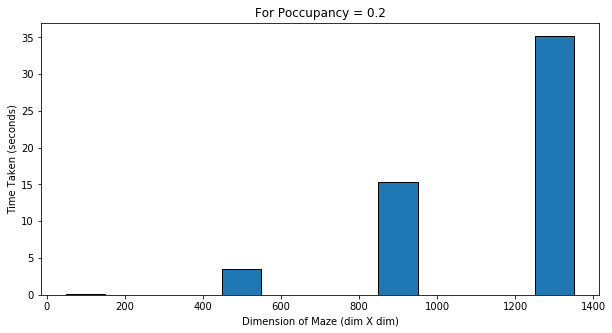

In [0]:
# The following data has been taken from the above data
dim_arr = [100, 500, 900, 1300]
tt = [0.0782, 3.47, 15.4, 35.2]

plt.figure(figsize=(10, 5))
plt.bar(x=dim_arr, height=tt, width=[100]*len(tt), edgecolor="black", align="center")
plt.title(label="For Poccupancy = 0.2")
plt.xlabel(xlabel="Dimension of Maze (dim X dim)")
plt.ylabel(ylabel="Time Taken (seconds)")
plt.show()


Q 2b ) Run the below codes to test all the algorithms, rerun with a lower probability if path is not found

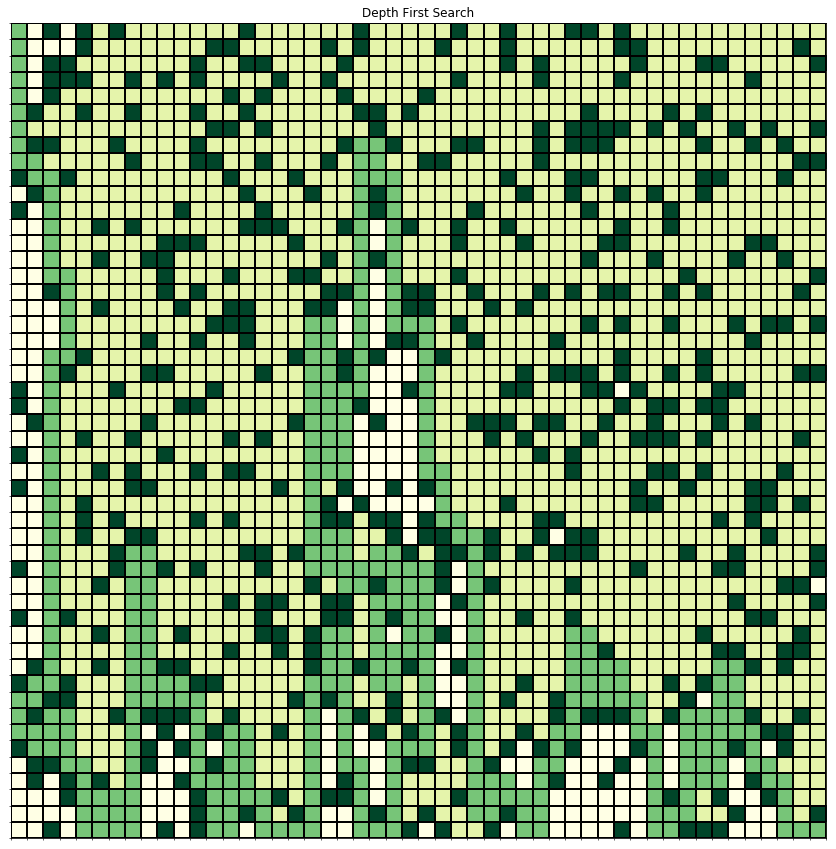

In [0]:
# DFS Algorithm 
test('dfs', 50, 0.2, 15)

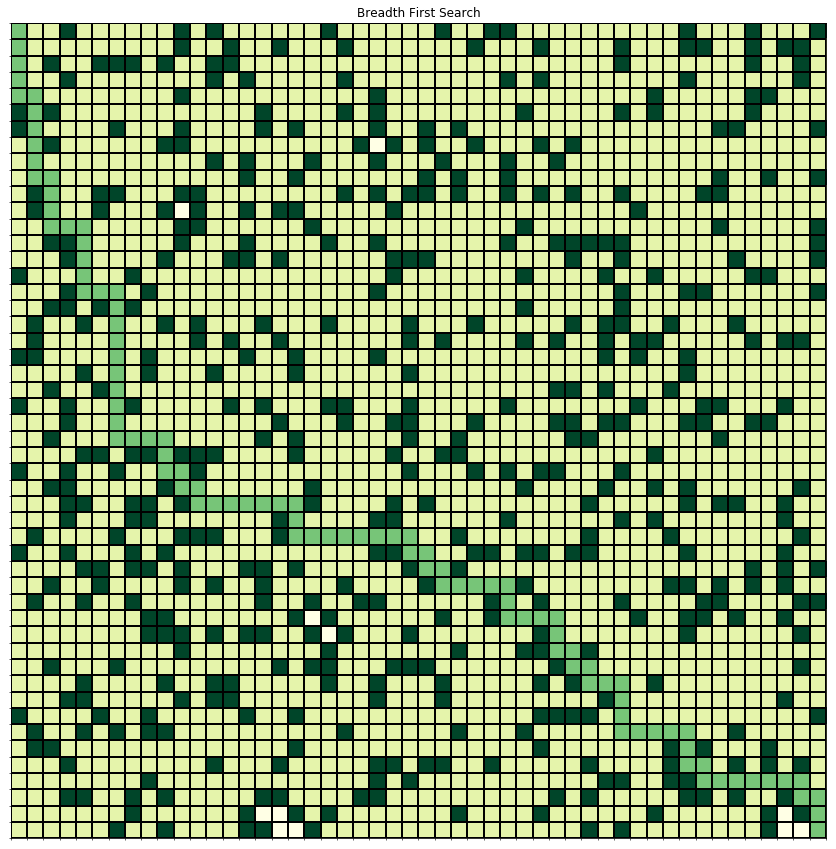

In [0]:
# BFS Algorithm 
test('bfs', 50, 0.2, 15)

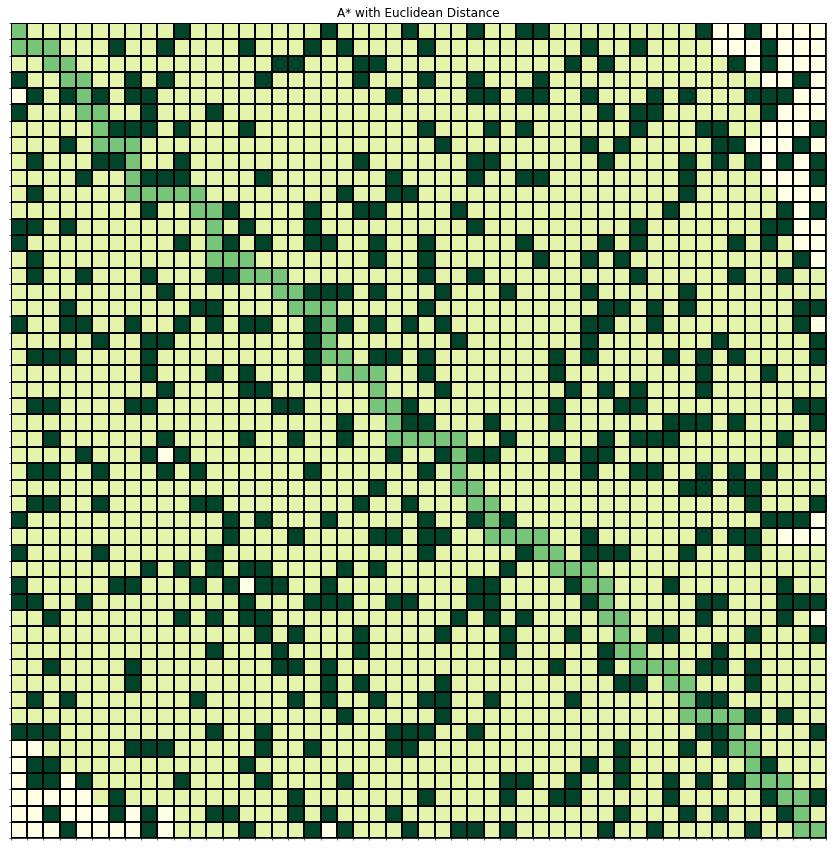

In [0]:
# A* with Euclidean Algorithm 
test('astar', 50, 0.2, 15,'euclidean')

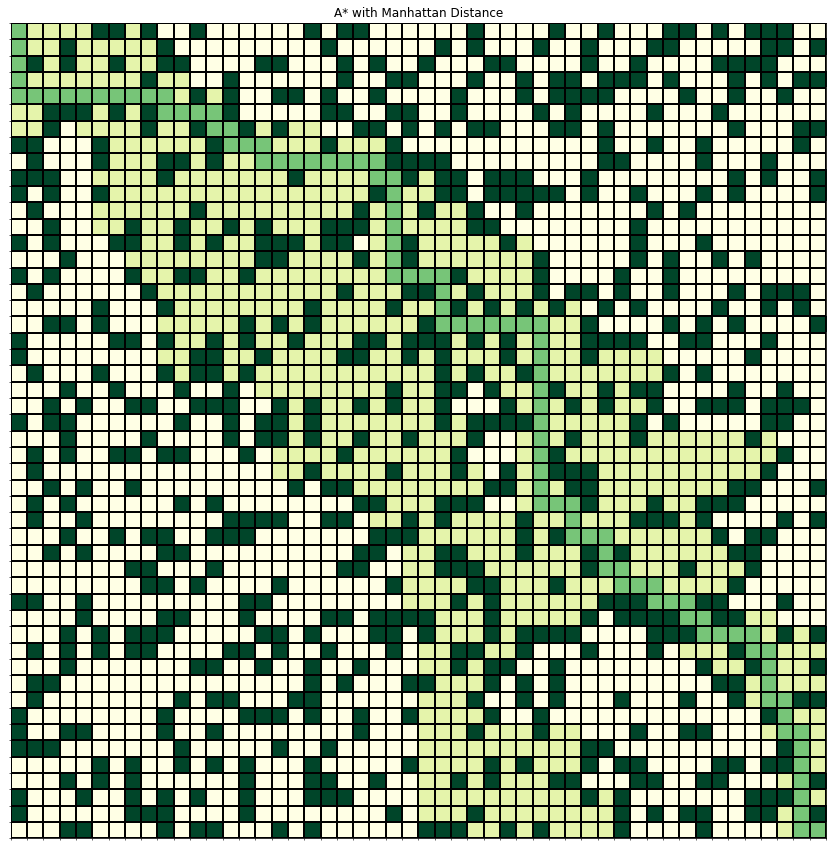

In [0]:
# A* with Euclidean Algorithm 
test('astar', 50, 0.3, 15,'manhattan')

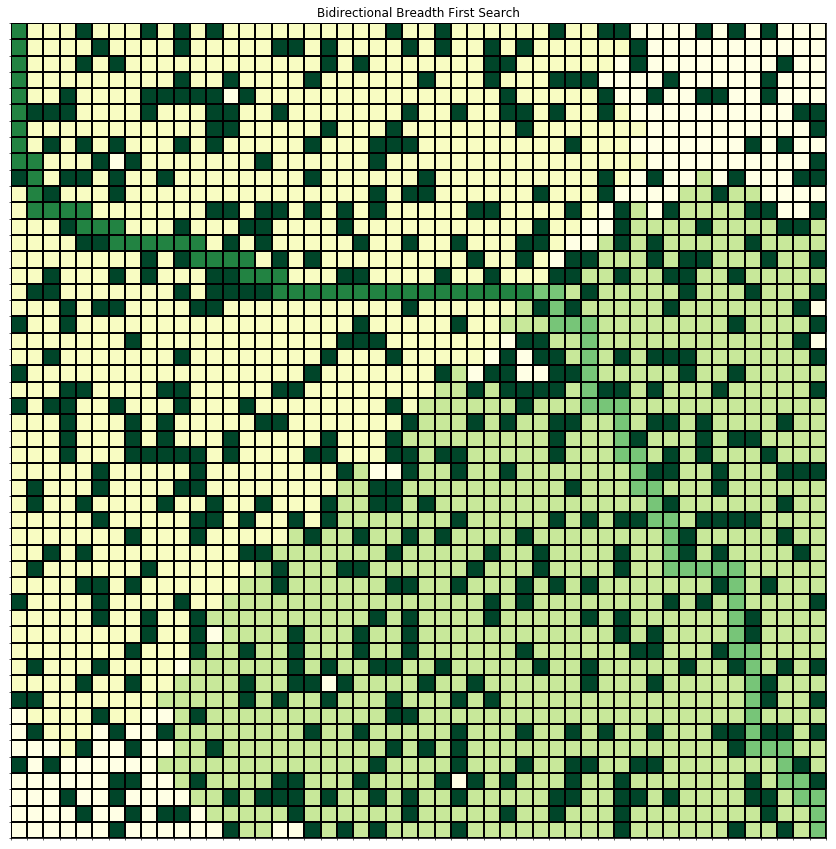

In [0]:
test('bdbfs', 50, 0.2, 15)

Q 2 c)


In [0]:
solvability = {}
density = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for p in density:
    solvability[p] = 0
    
def simulate(p: int, l: Lock):
    sim_count = 1000
    dim = 500
    for i in range(sim_count):
        maze = Maze()
        maze.generate_maze(dim, p)
        sp = SearchPath(maze)  
        path = sp.dfs()
        if path:
            l.acquire()
            solvability[p] += 1
            l.release()
    l.acquire()
    print(p, solvability[p])
    l.release()
    
proc_arr = []
l = Lock()
for p in density:
    proc = Process(target=simulate, args=(p, l))
    proc.start()
    proc.join()
    proc_arr.append(proc)

0.26 1000
0.27 1000


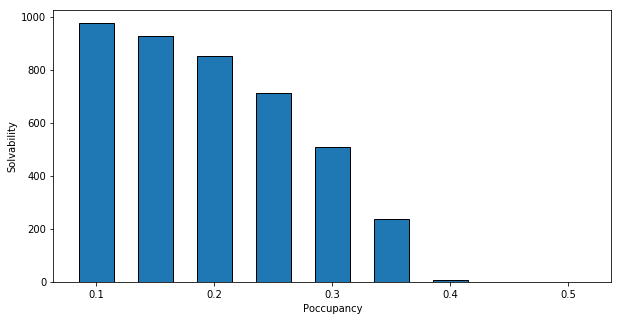

In [0]:
# The following data has been taken from the above function
density = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
solvability = [976, 926, 853, 710, 509, 237, 8, 0, 0]
plt.figure(figsize=(10, 5))
plt.bar(x=density, height=solvability, width=[0.03]*len(density), edgecolor="black", align="center")
# plt.title(label="For Poccupancy = 0.2")
plt.xlabel(xlabel="Poccupancy")
plt.ylabel(ylabel="Solvability")
plt.show()
# density = [0.25, 0.26, 0.27, 0.28, 0.29, 0.30]
# solvability = [710, 663, 620, 602, 562, 509] 
# plt.bar(x=density, height=solvability, width=[0.005]*len(solvability), edgecolor="black", align="center")
# plt.show()

[ 54276.09427609 -48570.12987013   9938.05435305    388.57936508]
[ 9.50959596e+02  9.69641414e+02  8.67593795e+02  6.85523810e+02
  4.64138528e+02  2.44145022e+02  6.62503608e+01 -2.88383838e+01
 -4.14141414e-01]


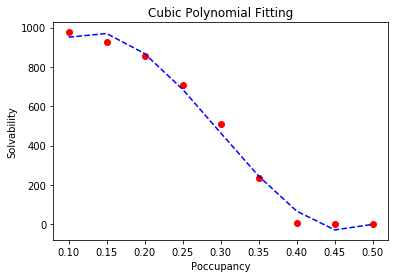

In [0]:

density = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
solvability = [976, 926, 853, 710, 509, 237, 8, 0, 0]
# fitting polynomial curve
params = np.polyfit(density, solvability, 3)
# c0*x^2 + c1*x + x2
print(params)
ans = np.polyval(params, density)
print(ans)
plt.plot(density, solvability, 'o', color ='red', label ="data")
plt.plot(density, ans, '--', color='blue', label ="fitted data") 
plt.title(label="Cubic Polynomial Fitting")
plt.xlabel(xlabel="Poccupancy")
plt.ylabel(ylabel="Solvability")
plt.show()


(array([1949.09721887,   -5.33228187]), array([[ 1.91624563e+05, -4.71647557e+02],
       [-4.71647557e+02,  1.44688138e+00]]))


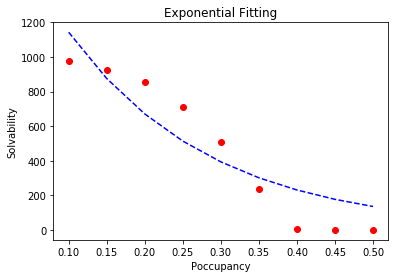

In [0]:
# Exponential Fitting
# params = np.polyfit(density[:-2], np.log(solvability[:-2]), 1)
e_params = curve_fit(lambda t,a,b: a*np.exp(b*t),  density,  solvability)
print(e_params)
e_params = e_params[0]

ans = []
for p in density:
    ans.append(e_params[0]*np.exp(e_params[1]*p))

plt.plot(density, solvability, 'o', color ='red', label ="data")
plt.plot(density, ans, '--', color='blue', label ="fitted data") 
plt.title(label="Exponential Fitting")
plt.xlabel(xlabel="Poccupancy")
plt.ylabel(ylabel="Solvability")

plt.show()


Q 2 d)

In [0]:

p_range = np.arange(0.1, 0.35, 0.05)
    
def simulate(p: int):
    sps = []
    sim_count = 10
    dim = 500
    for i in range(sim_count):
        maze = Maze()
        maze.generate_maze(dim, p)
        sp = SearchPath(maze)  
        h = ManhattanDistance()
        h.pre_calc(maze)
        result = sp.a_star(h)
        if result.path:
            sps.append(len(result.path))
    if sps:
        print(p, statistics.mean(sps))
    else:
        print(p, "0 maps solved")
    
pool = Pool(processes=4)              # start 4 worker processes
pool.map(simulate, p_range)



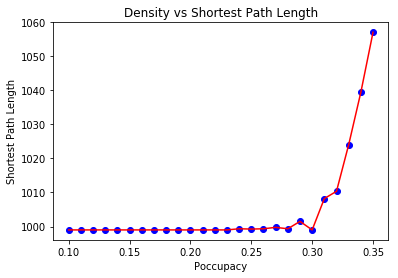

In [0]:
# Data generated from the previous function
data = """0.14\n999\n0.15\n999\n0.2\n999\n0.21\n999\n0.26\n999.3333333333334\n0.27\n999.75\n0.12\n999\n0.13\n999\n0.22\n999\n0.23\n999\n0.3\n999\n0.31\n1008.2\n0.16\n999\n0.17\n999\n0.18\n999\n0.19\n999\n0.32\n1010.3333333333334\n0.33\n1024\n0.1\n999\n0.11\n999\n0.24\n999.3333333333334\n0.25\n999.25\n0.28\n999.3333333333334\n0.29\n1001.5\n0.34\n1039.4\n0.35\n1057"""
density_v_path = {}

key = None
for i, val in enumerate(data.split('\n')):
    if i%2 == 0:
        key = float(val)
        density_v_path[key] = None
    else:
        density_v_path[key] = float(val)

sorted_data = sorted(density_v_path.items())
density, path_len = zip(*sorted_data)

plt.plot(density, path_len, 'o', color ='blue', label ="data")
plt.plot(density, path_len, '-', color ='red', label ="data")
plt.title(label="Density vs Shortest Path Length")
plt.xlabel(xlabel="Poccupacy")
plt.ylabel(ylabel="Shortest Path Length")
plt.show()


Q 2 e)

Q3 Genetic Algorithm with BFS

In [0]:
def genetic_algorithm( maze_prob : int, maze_sample_size: int, size : int, metric:str, algorithm : str,heuristics : str = 'euclidean') :
  
  maze_population = []
  counter = 0
  if metric not in ['max_path','max_fringe','max_visited'] :
    print("Error : Choose metric from max_path, max_fringe,max_visited")
    return
 



  # Generate the Initial sample space containing the parent mazes
  while True:
      maze=Maze()
      maze.generate_maze(size,maze_prob)
      sp = SearchPath(maze)
      algo = sp.get_algo(algorithm)
      if algorithm == 'astar' :
        if heuristics == 'euclidean' :
          h = EucledianDistance()
        else:
          h = ManhattanDistance()
        result = algo(h)
      else :
        result = algo()
      maze_population.append([maze,result.path,result.max_fringe,result.visited])
      if result.path:
         counter = counter +1
      else:
          maze_population.pop()

      if counter == maze_sample_size:
          break
   #####################################################################        
       
  # Print the initial length based on the metric
  if metric == 'max_path' :
    print([ len(x[1]) for x in maze_population   ])
  elif metric == 'max_fringe' :
    print([ x[2] for x in maze_population   ])
  elif metric == 'max_visited' :
    print([ len(x[3].keys()) for x in maze_population   ])
  
  
  
  lst=np.arange(maze_sample_size)
  maze_population[0][0].visualize_explored(maze_population[0][1],maze_population[0][3],15,"One of the initial maze in the sample")
  
  
  
  # Generating children from parents and mutating
  for i in range(100):
      maze_population_copy = maze_population.copy()
      np.random.shuffle(lst)
      for j in range( 0, maze_sample_size, 2):
          mother = maze_population[lst[j]]        
          mother=np.array(mother[0].map_arr)[:size//2,:size]

          father=maze_population[lst[j+1]]
          father=np.array(father[0].map_arr)[size//2:,:size]

          child = np.vstack((mother,father))

          # Mutating by randomly adding walls to the child
          for k in range( size * 2 ):
              i=np.random.randint(len(child))
              j=np.random.randint(len(child))
              if child[i,j]==0 :
                  child[i,j]=1

          maze_new = Maze()
          maze_new.set_maze(child.tolist())
          sp = SearchPath(maze_new)
          algo = sp.get_algo(algorithm)
          if algorithm == 'astar' :
            if heuristics == 'euclidean' :
              h = EucledianDistance()
            else:
              h = ManhattanDistance()
            result = algo(h)
          else :
            result = algo()

          if result.path:
              maze_population.append([maze_new,result.path,result.max_fringe,result.visited])
              
      # Metric to choose
      if metric == 'max_path' :
        maze_population = sorted(maze_population, key= lambda l:len(l[1]), reverse=True)
      elif metric == 'max_fringe' :
        maze_population = sorted(maze_population, key= lambda l:(l[2]), reverse=True)
      elif metric == 'max_visited' :
        maze_population = sorted(maze_population, key= lambda l:len(l[3].keys()), reverse=True)
      maze_population = maze_population[:maze_sample_size]
      
  # Print the length based on the metric    
  if metric == 'max_path' :
    print([ len(x[1]) for x in maze_population   ])
  elif metric == 'max_fringe' :
    print([ x[2] for x in maze_population   ])
  elif metric == 'max_visited' :
    print([ len(x[3].keys()) for x in maze_population   ])

  maze_population[0][0].visualize_explored(maze_population[0][1],maze_population[0][3],15,"Hardest Maze generated")

Q 2 h)

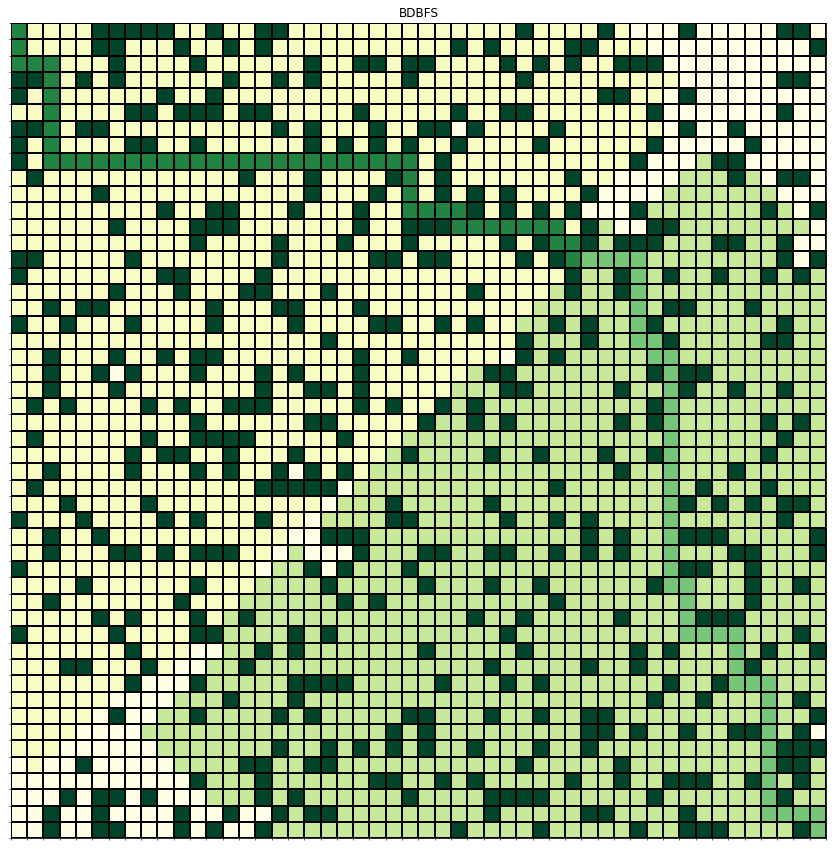

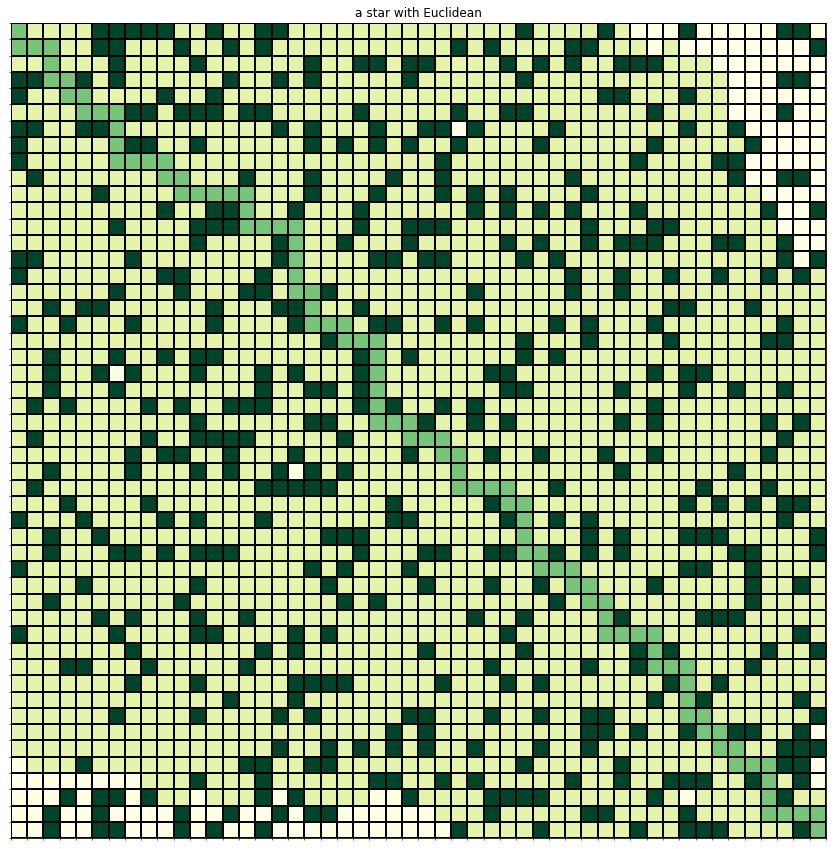

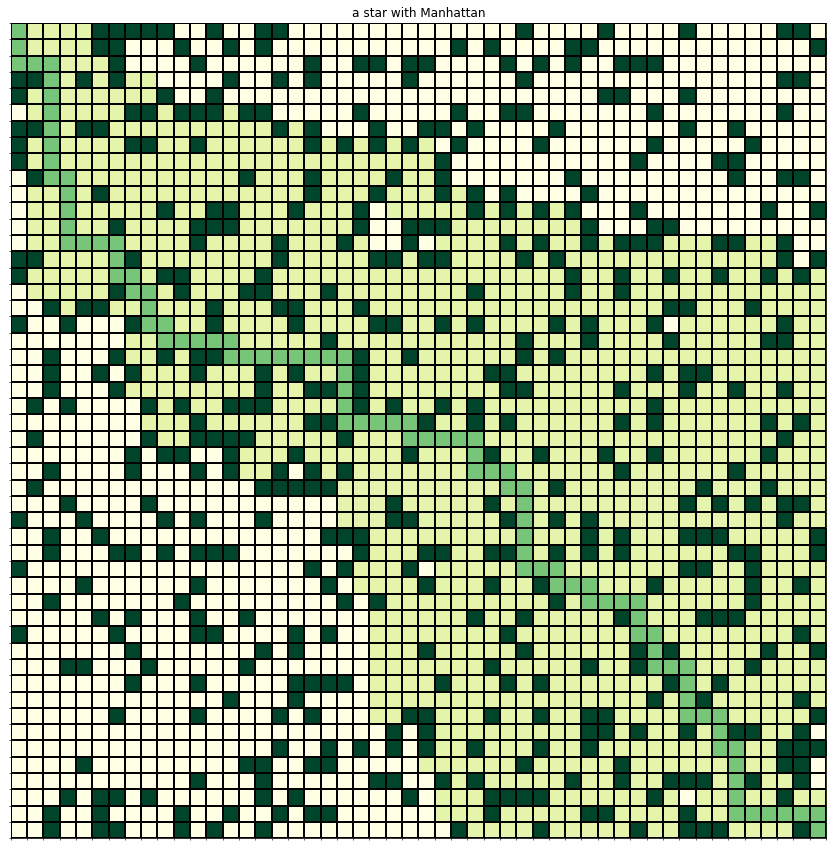

In [0]:
maze = Maze()
maze.generate_maze(50, 0.2)
sp = SearchPath(maze)
path_1,path_2,visited_1,visited_2 =  sp.bdbfs()
maze.visualize_explored_bdbfs(path_1,path_2,visited_1,visited_2,15,"BDBFS")

h =EucledianDistance()
result =sp.a_star(h)

maze.visualize_explored(result.path,result.visited,15,'a star with Euclidean')

h =ManhattanDistance()
result =sp.a_star(h)

maze.visualize_explored(result.path,result.visited,15,'a star with Manhattan')

Q 3 a)

[99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 99, 101, 99, 99, 99, 99, 99, 99, 99, 99]
[195, 189, 187, 179, 177, 153, 153, 153, 151, 149, 149, 149, 149, 149, 147, 147, 143, 143, 141, 141]


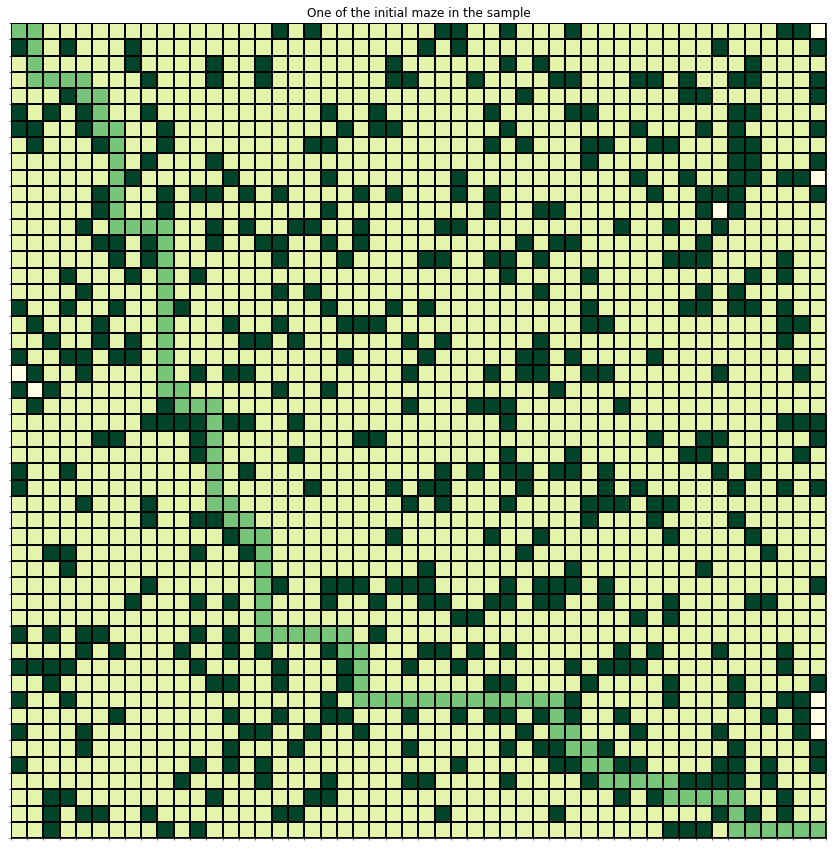

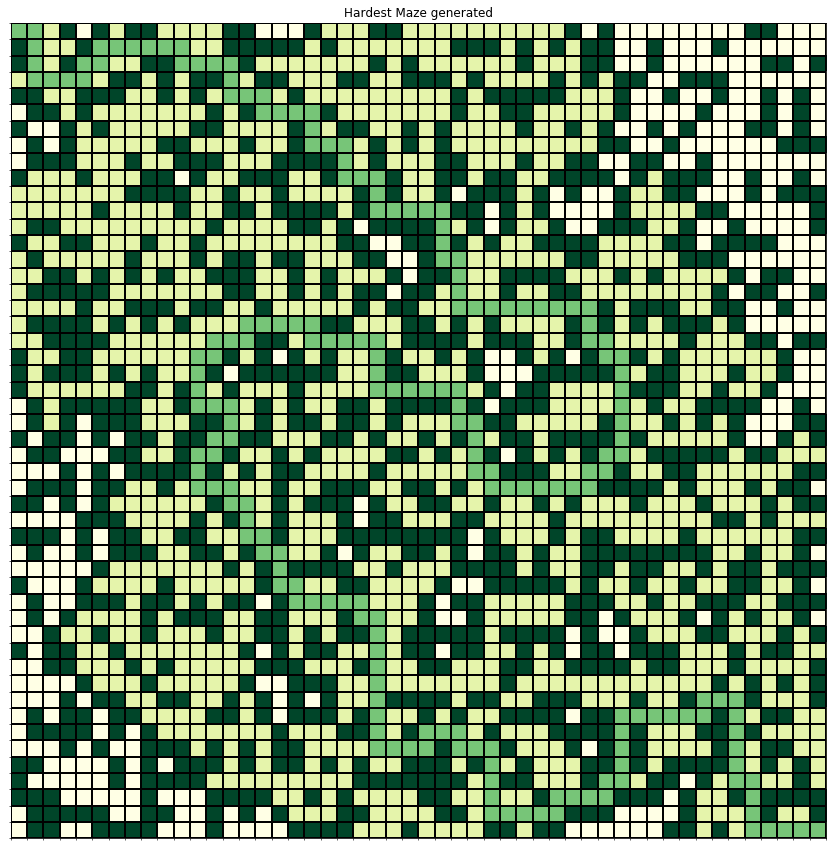

In [0]:
genetic_algorithm( 0.2, 20, 50,'max_path','bfs')

Q 3 c i)

[486, 662, 459, 371, 320, 888, 351, 334, 421, 465]
[888, 767, 744, 732, 723, 721, 714, 713, 698, 698]


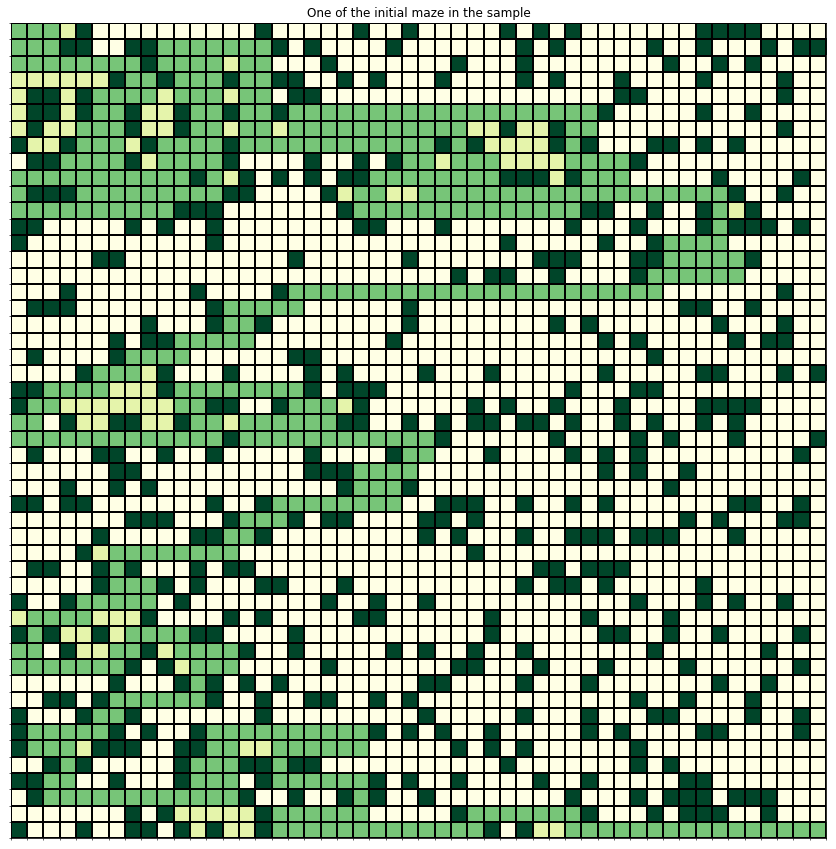

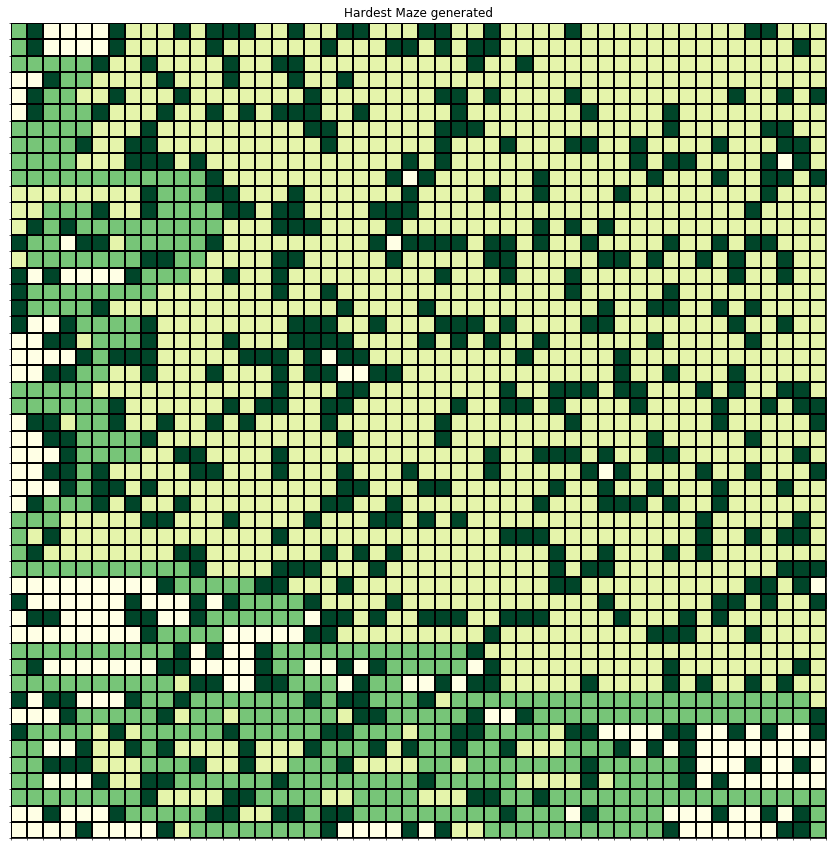

In [0]:
genetic_algorithm( 0.2, 10, 50,'max_fringe','dfs')

Q 3 c ii)


[1231, 1333, 1394, 1523, 1395, 1150, 1251, 1224, 1417, 1221]
[1712, 1682, 1675, 1662, 1654, 1653, 1650, 1649, 1644, 1637]


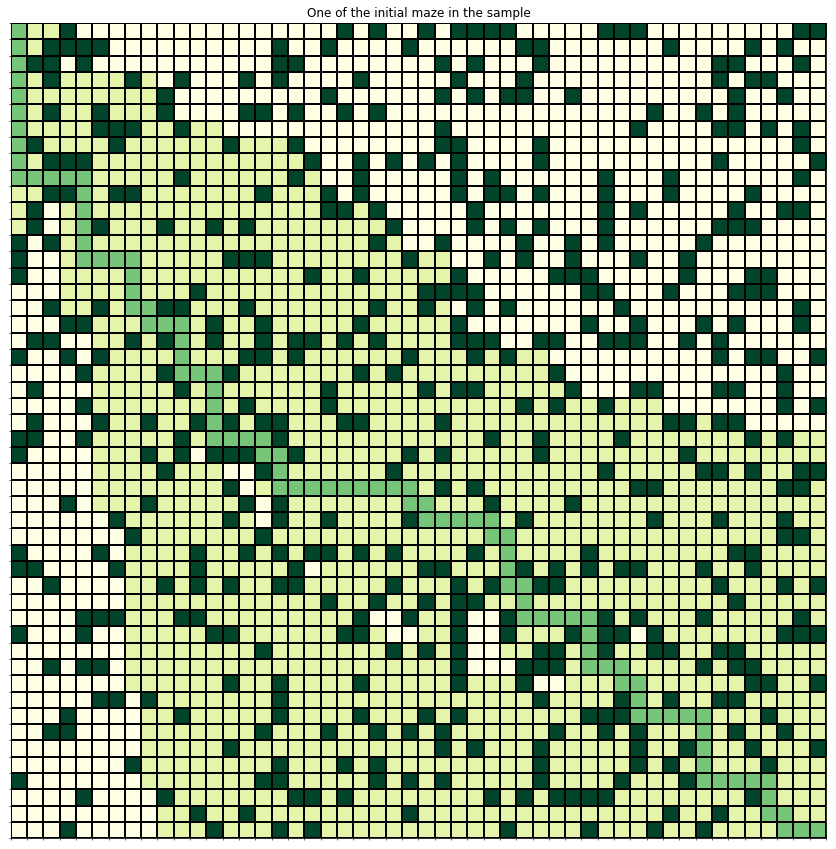

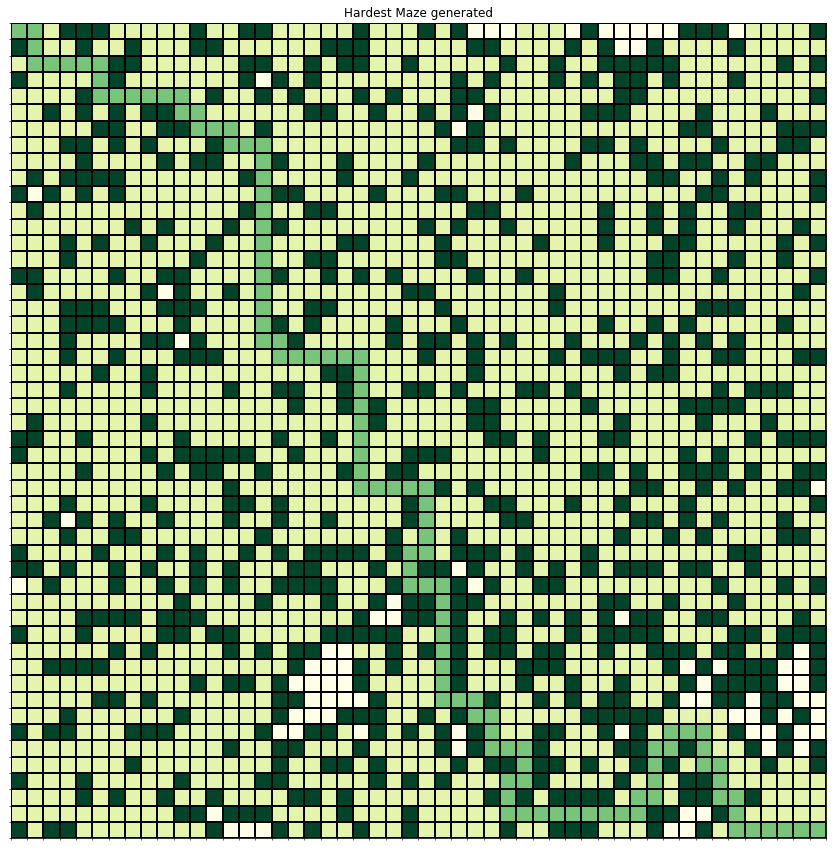

In [0]:
genetic_algorithm( 0.2, 10, 50,'max_visited','astar','manhattan')

Q 4 i) 

In [0]:
# a) Run the shortest path is fire
q_range = np.arange(0.05, 1, 0.05)

def simulate(q: int):
    print(f'Print Starting simulation for q = {q}')
    sim_count = 2
    dim = 10
    po = 0.2
    
    sol_count = 0
    for i in range(sim_count):
        maze = Maze()
        maze.generate_maze(dim, po)
#         maze.print_maze()
        sp = SearchPath(maze)  
        if sp.is_fair_for_fire():
            h = ManhattanDistance()
#             h.pre_calc(maze)
            result = sp.a_star(h)
            # result.path has a path
            if result.path:
                solved = sp.run_from_fire(result.path, q)
                if solved:
                    sol_count += 1
                    print(i, "solved")
                else:
                    print(i, "bitch got burned")
            else:
                print(i, "no path found")
        else:
            print(i, 'Not fair to fire')
#             print(sp.maze.print_maze())
    print("Solution", q, sol_count)
        
# pool = Pool(processes=1)              # start 4 worker processes
# pool.map(simulate, q_range)
simulate(0)

Q 4 ii)


In [0]:
# a) Run the shortest path is fire
q_range = np.arange(0.05, 1, 0.05)

def simulate(q: int):
    print(f'Print Starting simulation for q = {q}')
    sim_count = 2
    dim = 10
    po = 0.3
    
    sol_count = 0
    solvable = 0
    for i in range(sim_count):
        maze = Maze()
        maze.generate_maze(dim, po)
        sp = SearchPath(maze)  
        h = EucledianDistance()
        if sp.is_fair_for_fire():
            result = sp.dfs()
            # result.path has a path
            if result.path:
                solvable += 1
                solved = sp.adversial_search(h, q)
                if solved:
                    sol_count += 1
                    print(q, i, "solved")
                else:
                    print(q, i, "heehaa: you got burned")
            else:
                print(q, i, ":( no path found")
        else:
            print(q, i, 'Runner you cheat, I will get you next time - Fire')
#             print(sp.maze.print_maze())
    print("Solution", q, sol_count)
        
# pool = Pool(processes=1)              # start 4 worker processes
# pool.map(simulate, q_range)
simulate(0.3)